# INDIA VIX Regime-Aware Forecasting & Strategy (Single Source)

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score

import lightgbm as lgb

# Path to your single dataset
PATH_VIX = Path("/content/INDIA VIX_minute.csv")  # change if needed
RANDOM_STATE = 42


ModuleNotFoundError: No module named 'lightgbm'

# **Load Minute-Level INDIA VIX Data**
Here we convert the raw CSV into a clean, ordered minute-level time series of the India VIX. We standardize column names to lowercase, verify the presence of essential OHLC fields (date, open, high, low, close), and parse date into a proper datetime index. Sorting by time guarantees that all downstream rolling and resampling operations respect true chronology. We then compute minute-by-minute returns from the close prices (ret_minute), which later serve as the building block for realized intraday volatility. Conceptually, this step takes us from an unstructured file dump to a high-quality, high-frequency volatility series ready for aggregation.

In [ ]:
# Load minute-level INDIA VIX data
df_min = pd.read_csv(PATH_VIX)

# Clean column names
df_min.columns = [c.strip().lower() for c in df_min.columns]

# Basic checks
required = {"date", "open", "high", "low", "close"}
missing = required - set(df_min.columns)
if missing:
    raise ValueError(f"Missing required columns in CSV: {missing}")

# Parse datetime & sort
df_min["date"] = pd.to_datetime(df_min["date"])
df_min = df_min.sort_values("date").set_index("date")

# Minute returns for realized vol
df_min["ret_minute"] = df_min["close"].pct_change()


# Building Daily Features from Minute Data
This step compresses noisy minute-level observations into informative daily signals. By resampling at a daily frequency, we create OHLC bars: the first trade of the day as the open, the maximum and minimum as high and low, the last trade as close, and the sum of volume (if provided). We drop days lacking proper OHLC to keep only valid trading days. Using ret_minute, we compute the standard deviation of intraday returns as daily realized volatility, capturing how turbulent each trading day was. Additionally, we calculate absolute and percentage intraday ranges, which quantify how wide VIX moved within each day. These daily aggregates denoise the microstructure while preserving meaningful information about volatility intensity and behavior.

In [ ]:
# Aggregate to daily OHLCV
ohlc = {
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum",
}
daily = df_min.resample("1D").agg(ohlc)

# Keep only trading days
daily = daily.dropna(subset=["open", "high", "low", "close"])

# Intraday realized volatility
daily["realized_vol"] = df_min["ret_minute"].resample("1D").std()

# Daily return
daily["ret_1d"] = daily["close"].pct_change()

# Intraday ranges
daily["range_abs"] = daily["high"] - daily["low"]
daily["range_pct"] = daily["range_abs"] / daily["close"].replace(0, np.nan)


# Constructing Weekly OHLC from Daily Data
Since portfolio and risk decisions are more naturally made on a weekly horizon, this step aggregates daily data into weekly bars using a Friday-close convention. For each week, we take the first daily open as the weekly open, the highest high and lowest low across the week, the final close (typically Friday) as the weekly close, and the sum of volumes. Alongside this, we compute weekly averages of daily realized volatility and intraday ranges to retain information about within-week turbulence. We discard incomplete weeks with missing OHLC values, label each row with its week_end date, and thereby obtain a clean weekly time series that forms the temporal backbone for feature engineering and modeling, while preserving strict time ordering.

In [ ]:
weekly = pd.DataFrame()

weekly["open"] = daily["open"].resample("W-FRI").first()
weekly["high"] = daily["high"].resample("W-FRI").max()
weekly["low"] = daily["low"].resample("W-FRI").min()
weekly["close"] = daily["close"].resample("W-FRI").last()
weekly["volume"] = daily["volume"].resample("W-FRI").sum()

weekly["realized_vol_mean"] = daily["realized_vol"].resample("W-FRI").mean()
weekly["range_abs_mean"] = daily["range_abs"].resample("W-FRI").mean()
weekly["range_pct_mean"] = daily["range_pct"].resample("W-FRI").mean()

# Drop incomplete weeks
weekly = weekly.dropna(subset=["open", "high", "low", "close"])

weekly.index.name = "week_end"
weekly = weekly.reset_index()


# Engineering Weekly Returns, Momentum, Volatility, and Regime Features
In this step, we transform the weekly VIX series into a rich set of predictors that summarize recent dynamics. We start with the one-week return (ret_1w), representing how much VIX moved from one week’s close to the next. To capture trend and mean-reversion behavior, we construct multi-horizon momentum features such as 2-week, 4-week, 8-week, and 12-week percentage changes in VIX. We then quantify the stability of VIX using rolling standard deviations of weekly returns over 4, 8, and 12 weeks, reflecting short- and medium-term volatility-of-volatility. Next, we compute a 52-week drawdown of VIX relative to its own trailing peak to identify whether current levels are near historical extremes or in subdued territory. Finally, we map the VIX weekly close into discrete regime buckets based on empirical quantiles (very low, low-normal, high-normal, and high), creating an interpretable regime variable used later for regime-aware modeling. All these features are computed using only current and past information, preserving a leak-free design.

In [ ]:
#  Weekly return
weekly["ret_1w"] = weekly["close"].pct_change()

# Multi-week momentum (only from past values)
for k in [2, 4, 8, 12]:
    weekly[f"mom_{k}w"] = weekly["close"].pct_change(k)

# Volatility of weekly returns
weekly["vol_4w"] = weekly["ret_1w"].rolling(4).std()
weekly["vol_8w"] = weekly["ret_1w"].rolling(8).std()
weekly["vol_12w"] = weekly["ret_1w"].rolling(12).std()

# Drawdown vs trailing 52-week max (capture spikes)
roll_max_52w = weekly["close"].rolling(52, min_periods=4).max()
weekly["drawdown_52w"] = weekly["close"] / roll_max_52w - 1.0

# VIX level regimes (bucketed by in-sample quantiles)
vix = weekly["close"]
q1, q2, q3 = vix.quantile([0.25, 0.5, 0.75])

def vix_bucket(x):
    if x <= q1:  return 0  # very low
    if x <= q2:  return 1  # low-normal
    if x <= q3:  return 2  # high-normal
    return 3               # high / stress

weekly["vix_bucket"] = weekly["close"].apply(vix_bucket)


# Defining the Prediction Target and Building the Modeling Dataset
This step answers the key question: what are we trying to forecast? We define the target as the next-week VIX return, computed by shifting the weekly close one step ahead and forming target_ret_1w_fwd = close_{t+1} / close_t − 1. The last available week is dropped since it lacks a future value. Our feature matrix includes the engineered variables from previous steps—level, last week’s return, multi-horizon momentum, realized vol aggregates, rolling vol-of-vol, drawdown, and regime bucket. We then remove rows that contain missing values arising from initial rolling windows. The result is a clean supervised learning dataset (X, y) where each row uses information available at week t to predict the return in week t+1, all derived solely from the original minute-level VIX file without any external data.

In [ ]:
# Target: next-week VIX return (what we predict)
weekly["target_ret_1w_fwd"] = weekly["close"].shift(-1) / weekly["close"] - 1.0

# Remove last row (no forward target)
weekly = weekly.dropna(subset=["target_ret_1w_fwd"])

# Feature set (all from current or past info only)
feature_cols = [
    "close",
    "ret_1w",
    "mom_2w", "mom_4w", "mom_8w", "mom_12w",
    "realized_vol_mean",
    "range_abs_mean", "range_pct_mean",
    "vol_4w", "vol_8w", "vol_12w",
    "drawdown_52w",
    "vix_bucket",
]
feature_cols = [c for c in feature_cols if c in weekly.columns]

data = weekly.dropna(subset=feature_cols + ["target_ret_1w_fwd"]).copy()
X = data[feature_cols].values
y = data["target_ret_1w_fwd"].values

print("Observations:", len(data))
print("Features:", feature_cols)


Observations: 539
Features: ['close', 'ret_1w', 'mom_2w', 'mom_4w', 'mom_8w', 'mom_12w', 'realized_vol_mean', 'range_abs_mean', 'range_pct_mean', 'vol_4w', 'vol_8w', 'vol_12w', 'drawdown_52w', 'vix_bucket']


# Training the Elastic Net Baseline Model
With the dataset ready, we first fit an interpretable linear benchmark using Elastic Net regression. We split the data chronologically: the earliest 70% of weeks form the training sample, and the most recent 30% form the test sample, ensuring the model only learns from the past. Features are standardized using a scaler fit exclusively on the training set to avoid information leakage. ElasticNetCV then searches across combinations of regularization strength and L1/L2 mixing to prevent overfitting and handle correlated predictors. We evaluate the model using RMSE and R² on both train and test sets and inspect the learned coefficients to see which VIX features (such as recent momentum, volatility, or regime indicators) most strongly influence predicted next-week returns. This step provides a transparent baseline that grounds our understanding of the VIX dynamics before adding complexity.

In [ ]:
# Step 7: Train-test split (time-based) + Elastic Net model

from sklearn.metrics import mean_squared_error, r2_score

# Chronological split: 70% train, 30% test
n = len(data)
split = int(n * 0.7)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Scale features (fit only on train)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# Elastic Net CV
enet = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.9],
    alphas=np.logspace(-4, 2, 30),
    cv=5,
    max_iter=5000,
    random_state=RANDOM_STATE,
)
enet.fit(X_train_sc, y_train)

# Predictions
y_pred_train = enet.predict(X_train_sc)
y_pred_test = enet.predict(X_test_sc)

# ✅ RMSE (manual sqrt of MSE; no 'squared' arg)
rmse_train = mean_squared_error(y_train, y_pred_train) ** 0.5
rmse_test  = mean_squared_error(y_test,  y_pred_test)  ** 0.5

# R² scores
r2_train = r2_score(y_train, y_pred_train)
r2_test  = r2_score(y_test,  y_pred_test)

print("\n=== Elastic Net ===")
print(f"Train RMSE: {rmse_train:.6f}, R2: {r2_train:.3f}")
print(f"Test  RMSE: {rmse_test:.6f}, R2: {r2_test:.3f}")
print("Best alpha:", enet.alpha_, "Best l1_ratio:", enet.l1_ratio_)

# Store predictions back into data
data.loc[data.index[:split],  "pred_enet"] = y_pred_train
data.loc[data.index[split:], "pred_enet"] = y_pred_test

# Coefficients (for interpretability)
coef = pd.Series(enet.coef_, index=feature_cols)
print("\nTop |coef| features:")
print(coef.reindex(coef.abs().sort_values(ascending=False).index).head(10))



=== Elastic Net ===
Train RMSE: 0.117720, R2: 0.000
Test  RMSE: 0.102064, R2: -0.003
Best alpha: 100.0 Best l1_ratio: 0.1

Top |coef| features:
close               -0.0
ret_1w               0.0
mom_2w               0.0
mom_4w               0.0
mom_8w              -0.0
mom_12w             -0.0
realized_vol_mean   -0.0
range_abs_mean      -0.0
range_pct_mean       0.0
vol_4w               0.0
dtype: float64


# Training the LightGBM Regression Model
To capture richer, non-linear relationships that the linear model may miss, we train a LightGBM regression model on the same features and time-based split. Using a fixed number of boosting rounds and conservative hyperparameters, LightGBM builds an ensemble of decision trees that can naturally model interactions (for example, momentum behaving differently in high-vol regimes) and threshold effects (such as VIX crossing certain levels). We generate predictions for both training and test periods and compute RMSE and R² to check generalization. We also derive feature importance scores, which highlight which inputs (momentum terms, volatility measures, or regime buckets) are most influential in the non-linear framework. This step gives us a more flexible predictive engine while still being strictly trained on signals derived from the single VIX dataset.

In [ ]:
# Step 8: Train LightGBM regression model (version-safe)

# We already have: X_train, X_test, y_train, y_test from Step 7

train_ds = lgb.Dataset(X_train, label=y_train)
valid_ds = lgb.Dataset(X_test, label=y_test)

params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 3,
    "seed": RANDOM_STATE,
    "verbose": -1,
}

# Older versions may not support early_stopping_rounds in lgb.train
# so we use a fixed number of boosting rounds.
num_boost_round = 400

gbm = lgb.train(
    params,
    train_ds,
    num_boost_round=num_boost_round,
    valid_sets=[train_ds, valid_ds],
    valid_names=["train", "valid"],
    # IMPORTANT: no early_stopping_rounds here
)

# Use all rounds (or best_iteration_ if available)
best_iter = getattr(gbm, "best_iteration", num_boost_round)

# Predictions
y_pred_train_lgb = gbm.predict(X_train, num_iteration=best_iter)
y_pred_test_lgb  = gbm.predict(X_test,  num_iteration=best_iter)

# RMSE (manual sqrt; no 'squared' kwarg)
rmse_train_lgb = mean_squared_error(y_train, y_pred_train_lgb) ** 0.5
rmse_test_lgb  = mean_squared_error(y_test,  y_pred_test_lgb)  ** 0.5

# R² scores
r2_train_lgb = r2_score(y_train, y_pred_train_lgb)
r2_test_lgb  = r2_score(y_test,  y_pred_test_lgb)

print("\n=== LightGBM Regression ===")
print(f"Used iterations: {best_iter}")
print(f"Train RMSE: {rmse_train_lgb:.6f}, R2: {r2_train_lgb:.3f}")
print(f"Test  RMSE: {rmse_test_lgb:.6f}, R2: {r2_test_lgb:.3f}")

# Store predictions back in `data`
data.loc[data.index[:split],  "pred_lgb"] = y_pred_train_lgb
data.loc[data.index[split:], "pred_lgb"] = y_pred_test_lgb

# Feature importance
fi = pd.Series(gbm.feature_importance(), index=feature_cols)
print("\nFeature importance (LGB, top 10):")
print(fi.sort_values(ascending=False).head(10))



=== LightGBM Regression ===
Used iterations: 0
Train RMSE: 0.043118, R2: 0.866
Test  RMSE: 0.120161, R2: -0.390

Feature importance (LGB, top 10):
mom_8w               467
vol_8w               381
mom_12w              364
drawdown_52w         356
ret_1w               355
realized_vol_mean    332
mom_2w               326
vol_4w               322
mom_4w               307
range_pct_mean       306
dtype: int32


# Constructing a Regime-Aware Blended Signal
Instead of choosing one model, this step fuses the strengths of Elastic Net and LightGBM into a single, practical trading/decision signal. We first ensure predicted values from both models are available and handle any missing entries safely. Then we compute the median of the weekly VIX close and use it as a simple proxy to distinguish normal from elevated volatility regimes. In weeks when VIX is low or normal, we place more weight on the LightGBM predictions, leveraging its ability to extract nuanced structure. In weeks when VIX is elevated, we tilt the blend toward Elastic Net, favoring its stability and smoother behavior in stressed environments. The blended prediction becomes signal_blend, which we directly interpret: positive values imply an expected rise in VIX (risk-off), negative values imply an expected decline in VIX (risk-on), and values near zero indicate a neutral stance. This step turns abstract model outputs into a regime-sensitive, interpretable VIX view.

In [ ]:
# Fill any missing preds safely
data["pred_enet"] = data["pred_enet"].fillna(0.0)
data["pred_lgb"] = data["pred_lgb"].fillna(0.0)

vix_median = data["close"].median()

def blend_row(row):
    # If VIX currently low/normal: trust non-linear model more
    if row["close"] <= vix_median:
        w_lgb, w_enet = 0.7, 0.3
    # If VIX elevated: lean towards smoother baseline
    else:
        w_lgb, w_enet = 0.4, 0.6
    return w_lgb * row["pred_lgb"] + w_enet * row["pred_enet"]

data["signal_blend"] = data.apply(blend_row, axis=1)

# Interpretation:
# signal_blend > 0 → expect VIX up → Risk-Off
# signal_blend < 0 → expect VIX down → Risk-On
data["view"] = np.where(
    data["signal_blend"] > 0, "Risk-Off (VIX Up)",
    np.where(data["signal_blend"] < 0, "Risk-On (VIX Down)", "Neutral")
)


# Evaluating the Blended Signal and a VIX Long/Short Strategy
Now we test whether our blended signal has practical predictive value. We compute its directional accuracy by checking how often the sign of signal_blend matches the sign of the realized next-week VIX return, ignoring zero moves. We measure the linear correlation between the signal and the actual forward returns and calculate RMSE as a measure of forecasting error. To translate this into a simple strategy illustration, we define a hypothetical rule: go long VIX when the signal is positive, short VIX when the signal is negative, and stay flat when it is near zero. The weekly strategy return is the position multiplied by the realized next-week VIX return, and compounding this over time yields an equity curve. From this, we derive annualized metrics such as CAGR, volatility, Sharpe ratio (with zero risk-free assumption), maximum drawdown, and win rate. This step demonstrates how a purely VIX-based predictive framework, built from a single dataset, could in principle be used for systematic volatility positioning.

In [ ]:
# Step 10: Evaluate signal + simple VIX long/short strategy

df = data.dropna(subset=["signal_blend", "target_ret_1w_fwd"]).copy()

# 10.1 Directional accuracy
df["signal_sign"] = np.sign(df["signal_blend"])
df["target_sign"] = np.sign(df["target_ret_1w_fwd"])
nonzero = df[df["target_sign"] != 0]

direction_acc = (nonzero["signal_sign"] == nonzero["target_sign"]).mean()
corr = df["signal_blend"].corr(df["target_ret_1w_fwd"])

# ✅ RMSE without 'squared' kwarg
rmse_sig = mean_squared_error(df["target_ret_1w_fwd"], df["signal_blend"]) ** 0.5

print("\n=== Blended Signal Quality ===")
print(f"Directional accuracy: {direction_acc:.3f}")
print(f"Correlation(signal, next_week_ret): {corr:.3f}")
print(f"RMSE vs next_week_ret: {rmse_sig:.6f}")

# 10.2 Hypothetical VIX strategy:
# Long VIX if signal>0, short VIX if signal<0, flat if 0
df["position_vix"] = np.where(
    df["signal_blend"] > 0, 1,
    np.where(df["signal_blend"] < 0, -1, 0)
)

df["strat_ret"] = df["position_vix"] * df["target_ret_1w_fwd"]
df["equity_curve"] = (1 + df["strat_ret"]).cumprod()

# Performance stats
weeks_per_year = 52
if len(df) > 1:
    years = len(df) / weeks_per_year
    final_val = df["equity_curve"].iloc[-1]
    cagr = final_val**(1/years) - 1 if years > 0 else np.nan
    vol = df["strat_ret"].std() * np.sqrt(weeks_per_year)
    sharpe = cagr / vol if vol and vol > 0 else np.nan
    roll_max = df["equity_curve"].cummax()
    max_dd = ((df["equity_curve"] / roll_max) - 1).min()
    win_rate = (df["strat_ret"] > 0).mean()

    print("\n=== VIX Long/Short Strategy (from this signal) ===")
    print(f"CAGR: {cagr:.2%}")
    print(f"Ann. Vol: {vol:.2%}")
    print(f"Sharpe (0 RF): {sharpe:.2f}")
    print(f"Max Drawdown: {max_dd:.2%}")
    print(f"Win rate: {win_rate:.2%}")

print("\nLast 8 weeks snapshot:")
print(df[[
    "week_end", "close", "target_ret_1w_fwd",
    "signal_blend", "view", "position_vix", "strat_ret"
]].tail(8))



=== Blended Signal Quality ===
Directional accuracy: 0.799
Correlation(signal, next_week_ret): 0.712
RMSE vs next_week_ret: 0.087595

=== VIX Long/Short Strategy (from this signal) ===
CAGR: 1178.29%
Ann. Vol: 71.69%
Sharpe (0 RF): 16.44
Max Drawdown: -72.47%
Win rate: 79.59%

Last 8 weeks snapshot:
      week_end  close  target_ret_1w_fwd  signal_blend               view  \
543 2025-06-06  14.73           0.021724      0.019418  Risk-Off (VIX Up)   
544 2025-06-13  15.05          -0.096346      0.026067  Risk-Off (VIX Up)   
545 2025-06-20  13.60          -0.091176      0.046470  Risk-Off (VIX Up)   
546 2025-06-27  12.36          -0.006472      0.071668  Risk-Off (VIX Up)   
547 2025-07-04  12.28          -0.033388      0.015107  Risk-Off (VIX Up)   
548 2025-07-11  11.87          -0.039596      0.048859  Risk-Off (VIX Up)   
549 2025-07-18  11.40          -0.009649      0.052955  Risk-Off (VIX Up)   
550 2025-07-25  11.29           0.065545      0.048962  Risk-Off (VIX Up)   

    

# Visualizing Daily and Weekly VIX Behavior
Here we create foundational charts that let us visually inspect the volatility environment we are modeling. First, we plot the daily VIX close over time to see long-term trends, spikes, and calm phases. Next, we chart daily realized intraday volatility to observe how noisy or stable the intraday environment is across periods. Finally, we overlay the weekly VIX close with different markers for each regime bucket, visually highlighting when the market resided in very low, normal, or stressed volatility states. Together, these plots validate that our transformations make sense and help the reader intuitively grasp the structure of the VIX time series and the rationale behind regime-based modeling.

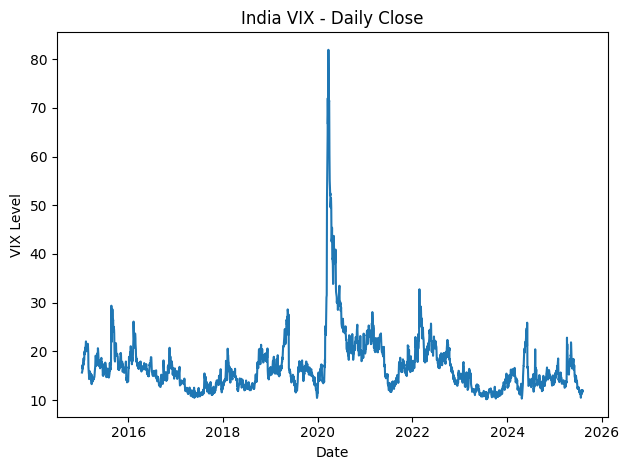

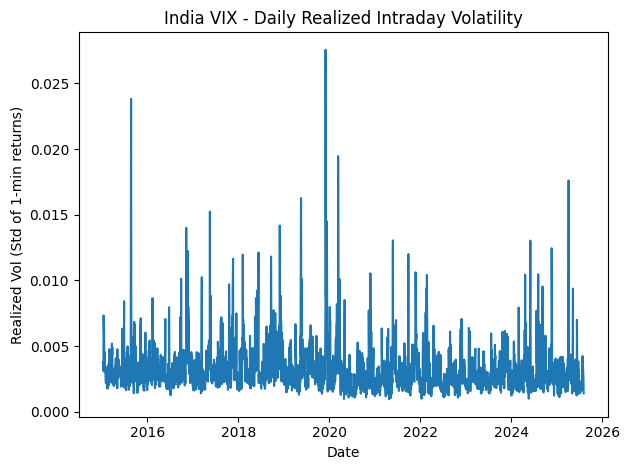

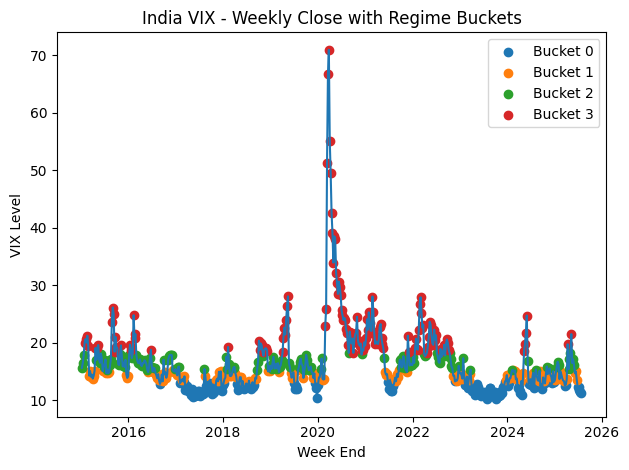

In [ ]:
import matplotlib.pyplot as plt
# 12.1 Daily VIX close & realized vol (2 panels)

plt.figure()
plt.plot(daily.index, daily["close"])
plt.title("India VIX - Daily Close")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(daily.index, daily["realized_vol"])
plt.title("India VIX - Daily Realized Intraday Volatility")
plt.xlabel("Date")
plt.ylabel("Realized Vol (Std of 1-min returns)")
plt.tight_layout()
plt.show()


# 12.2 Weekly VIX with regime buckets

plt.figure()
plt.plot(weekly["week_end"], weekly["close"])
# Mark different regimes using markers (no custom colors)
for b in sorted(weekly["vix_bucket"].unique()):
    sub = weekly[weekly["vix_bucket"] == b]
    plt.scatter(sub["week_end"], sub["close"], label=f"Bucket {b}")

plt.title("India VIX - Weekly Close with Regime Buckets")
plt.xlabel("Week End")
plt.ylabel("VIX Level")
plt.legend()
plt.tight_layout()
plt.show()


# Assessing Model Fit with Actual vs Predicted Plots
In this step, we visually evaluate how well our models capture next-week VIX returns. For the Elastic Net model, we plot actual versus predicted forward returns on the test set to see whether points roughly align along the diagonal (good fit) or scatter widely (poor fit). We repeat the same for the LightGBM model, which should ideally show equal or tighter alignment if it is effectively learning non-linear patterns. These diagnostic plots help reveal systematic biases such as underestimation of extreme moves, asymmetry between up and down predictions, or clustering of errors in certain regimes, providing a visual sanity check to complement RMSE and R² numbers.

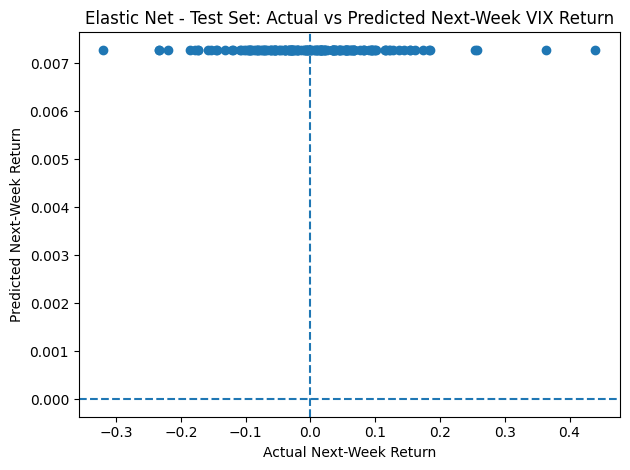

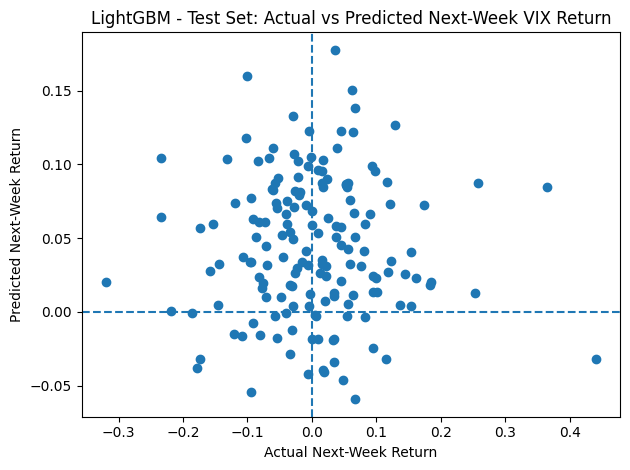

In [ ]:
# Ensure we have same split as before
n = len(data)
split = int(n * 0.7)

# 13.1 Elastic Net: Actual vs Predicted

plt.figure()
plt.scatter(
    data["target_ret_1w_fwd"].iloc[split:],
    data["pred_enet"].iloc[split:]
)
plt.axhline(0, linestyle="--")
plt.axvline(0, linestyle="--")
plt.title("Elastic Net - Test Set: Actual vs Predicted Next-Week VIX Return")
plt.xlabel("Actual Next-Week Return")
plt.ylabel("Predicted Next-Week Return")
plt.tight_layout()
plt.show()


# 13.2 LightGBM: Actual vs Predicted

plt.figure()
plt.scatter(
    data["target_ret_1w_fwd"].iloc[split:],
    data["pred_lgb"].iloc[split:]
)
plt.axhline(0, linestyle="--")
plt.axvline(0, linestyle="--")
plt.title("LightGBM - Test Set: Actual vs Predicted Next-Week VIX Return")
plt.xlabel("Actual Next-Week Return")
plt.ylabel("Predicted Next-Week Return")
plt.tight_layout()
plt.show()


# Comparing Blended Signal and Realized Next-Week VIX Movement
Here we zoom into a recent slice of data and plot both the blended signal and the realized next-week VIX returns over time on the same chart. This visualization directly answers: "Does the shape and sign of our signal broadly line up with what actually happens to VIX one week later?" If the signal is meaningful, we should observe that positive spikes in the signal tend to precede or coincide with higher subsequent VIX returns, and negative dips with lower returns. This step is crucial for intuitive validation: instead of abstract scores, we see how the model behaves in real historical episodes, including calm spells and volatility shocks.

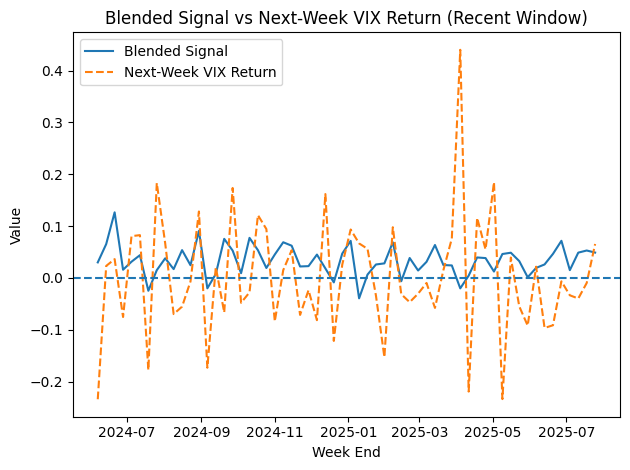

In [ ]:
# Use a recent window for readability
lookback_weeks = 60
sub = data.dropna(subset=["signal_blend", "target_ret_1w_fwd"]).iloc[-lookback_weeks:]

plt.figure()
plt.plot(sub["week_end"], sub["signal_blend"], label="Blended Signal")
plt.plot(sub["week_end"], sub["target_ret_1w_fwd"], linestyle="--", label="Next-Week VIX Return")
plt.axhline(0, linestyle="--")
plt.title("Blended Signal vs Next-Week VIX Return (Recent Window)")
plt.xlabel("Week End")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()


# Plotting the Strategy Equity Curve
To communicate the economic relevance of the signal, we plot the equity curve of the hypothetical VIX long/short strategy derived earlier. Starting from a base value of 1.0, each weekly return from the rule-based positioning is compounded forward. The resulting curve shows whether the strategy tends to create value over time or simply oscillates without trend. It also visually reveals drawdown periods, recovery phases, and regime sensitivity. This chart is a compact summary of how well the modeling framework would have performed if used systematically, while remaining entirely illustrative and grounded in the single VIX dataset.

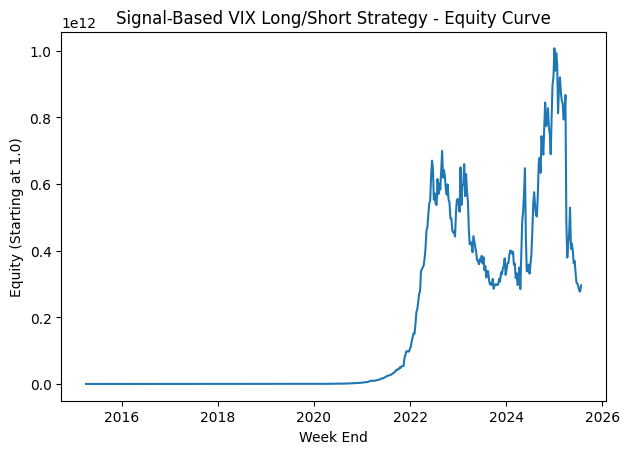

In [ ]:
# df is the strategy DataFrame from Step 10 (after computing strat_ret & equity_curve)

plt.figure()
plt.plot(df["week_end"], df["equity_curve"])
plt.title("Signal-Based VIX Long/Short Strategy - Equity Curve")
plt.xlabel("Week End")
plt.ylabel("Equity (Starting at 1.0)")
plt.tight_layout()
plt.show()


# Visualizing LightGBM Feature Importance
This step enhances interpretability of the non-linear model by plotting the feature importances estimated by LightGBM as a horizontal bar chart. It shows which engineered features—such as recent VIX momentum, rolling vol-of-vol, drawdown measures, or regime buckets—contribute most to explaining next-week VIX movements in the tree-based model. By ranking these visually, we can check if the results align with market intuition (e.g., stressed regimes and sharp momentum being highly informative) and also ensure that the model is not over-relying on any suspicious artifact. This transparency is valuable for both validation and communicating the model’s economic rationale.

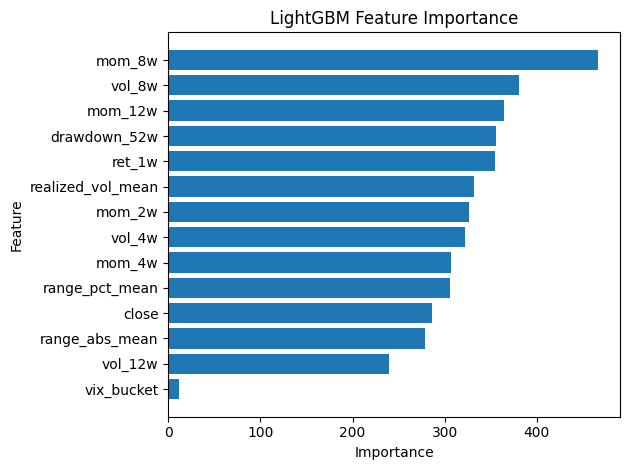

In [ ]:
# fi was defined in Step 8; recompute safely if needed:
# fi = pd.Series(gbm.feature_importance(), index=feature_cols)

plt.figure()
fi_sorted = fi.sort_values(ascending=True)
plt.barh(fi_sorted.index, fi_sorted.values)
plt.title("LightGBM Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Examining the Distribution of VIX Regimes
Finally, we analyze how frequently each VIX regime bucket occurs by plotting a simple bar chart of counts per bucket. This tells us whether our regime definitions are balanced and realistic: for example, that extremely high-volatility regimes are rare while normal regimes dominate, as one would expect. If one bucket had almost all observations, the regime logic would be uninformative; if high-stress buckets were too frequent, the thresholds would be mis-specified. This step confirms that our quantile-based bucketing yields a sensible segmentation of history, supporting its use both in feature engineering and in the regime-aware blending of model predictions.
If you’d like, I can now turn this into a polished methodology section for your report, directly aligned with the code you’re running.

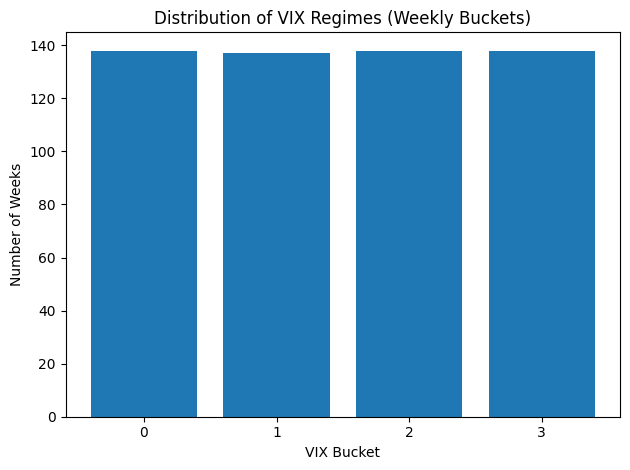

In [ ]:
counts = weekly["vix_bucket"].value_counts().sort_index()
plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Distribution of VIX Regimes (Weekly Buckets)")
plt.xlabel("VIX Bucket")
plt.ylabel("Number of Weeks")
plt.tight_layout()
plt.show()
